In [226]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

from sklearn.metrics import mean_squared_error
import os

In [227]:
prost_cancer_df = pd.read_csv(os.path.join('data', 'prostate_cancer.csv'), sep="\t").drop('Unnamed: 0', axis=1)
resp_names      = ['lpsa']
var_names       = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']

prost_cancer_df

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
...,...,...,...,...,...,...,...,...,...,...
92,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,T
93,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,T
94,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,F
95,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,T


In [ ]:
pd.plotting.scatter_matrix(prost_cancer_df[resp_names+var_names],
                            figsize    = (8, 8),
                            facecolors = "w",
                            edgecolors = "k")
#plt.savefig(os.path.join('figures', 'cancer_scatter_matrix.png'), dpi=300, transparent=True, bbox_inches = 'tight')



In [217]:
def residual_sum_of_squares(y, y_hat):
    return np.sum((y - y_hat)**2)

def ridge_reggression(X, y, alpha):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    return ridge

def normalize_data(x):
    x = x - np.mean(x, axis=0)
    x = x / np.std(x, axis=0)
    return x

In [218]:
train_df = prost_cancer_df[prost_cancer_df.train=="T"]
test_df  = prost_cancer_df[prost_cancer_df.train=="F"]

y_train = train_df[resp_names].values
X_train = train_df[var_names].values
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))

y_test = test_df[resp_names].values
X_test = test_df[var_names].values
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))


In [219]:
alphas = np.arange(0, 1 + 0.1, 0.01)

rss_train = np.full_like(alphas, fill_value=np.nan)
rss_test  = np.full_like(alphas, fill_value=np.nan)
β_ridge   = np.full((len(alphas), X_train.shape[1]), fill_value=np.nan)

for i_α, α in enumerate(alphas):
    ridge_model     = ridge_reggression(X_train, y_train, α)
    β_ridge[i_α, :] = ridge_model.coef_.flatten()

    rss_train[i_α]   = residual_sum_of_squares(ridge_model.predict(X_train), y_train)
    rss_test[i_α]    = residual_sum_of_squares(ridge_model.predict(X_test), y_test)


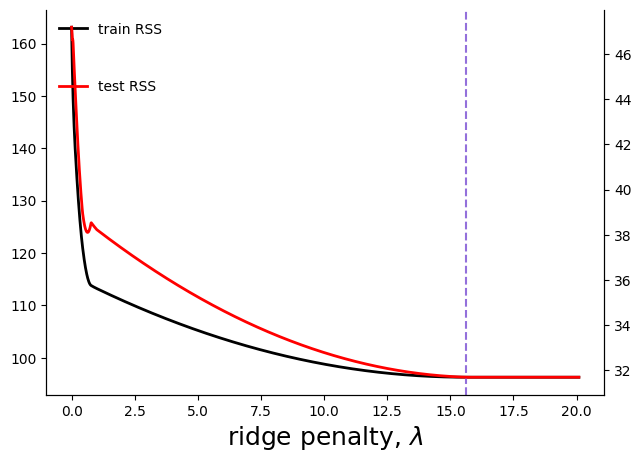

In [225]:
fig, ax = plt.subplots(1, 1, figsize=(7.2, 5), sharex=True)

ax.plot(alphas, rss_train/len(X_train), label="train RSS", color="k", lw=2)

ax_t = ax.twinx()
ax_t.plot(alphas, rss_test/len(X_test), label="test RSS", color="red", lw=2)

ax.legend(loc="upper left", frameon=False)
ax_t.legend(loc="upper left", frameon=False, bbox_to_anchor=(0.0, 0.85))

ax.spines["top"].set_visible(False)
ax_t.spines["top"].set_visible(False)

ax.set_xlabel(r"ridge penalty, $\lambda$", fontsize=18)

λ_hat  = np.argmin(rss_test)
ax.axvline(alphas[λ_hat], color="mediumpurple", linestyle="--")


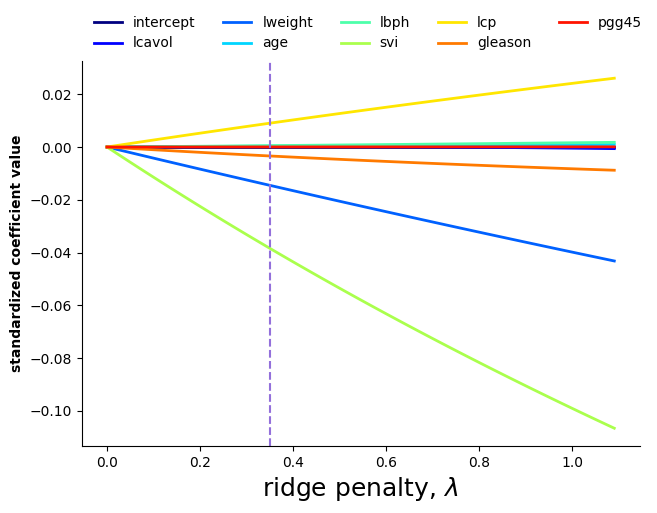

In [221]:
λ_hat  = np.argmin(rss_test)
labels = ["intercept"] + var_names
colors = plt.cm.jet(np.linspace(0, 1, len(labels)+1))

fig, ax = plt.subplots(1, 1, figsize=(7.2, 5), sharex=True)

for i_β in range(β_ridge.shape[1]):

    coefs_norm = β_ridge - np.expand_dims(β_ridge[0, :], 0)
    c   = colors[i_β]

    β_i = coefs_norm[:, i_β]
    ax.plot(alphas, β_i, label=labels[i_β], color=c, lw=2)

ax.axvline(alphas[λ_hat], color="mediumpurple", linestyle="--")
ax.set_xlabel(r"ridge penalty, $\lambda$", fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylabel(r"standardized coefficient value", weight="bold")
ax.legend(loc="upper left", frameon=False, bbox_to_anchor=(0.0, 1.15), ncol=5)

#ax.set_ylim(-0.035, 0.08113336113386853)

In [222]:
alphas = np.arange(0, 20. + 0.1, 0.01)

rss_train = np.full_like(alphas, fill_value=np.nan)
rss_test  = np.full_like(alphas, fill_value=np.nan)
β_lasso   = np.full((len(alphas), X_train.shape[1]), fill_value=np.nan)

for i_α, α in enumerate(alphas):
    lasso_model     = Lasso(α, fit_intercept=True).fit(X_train, y_train)
    β_lasso[i_α, :] = lasso_model.coef_.flatten()

    rss_train[i_α]   = residual_sum_of_squares(lasso_model.predict(X_train), y_train)
    rss_test[i_α]    = residual_sum_of_squares(lasso_model.predict(X_test), y_test)


/Users/chaosdonkey06/miniconda3/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/chaosdonkey06/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/chaosdonkey06/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.471e+01, tolerance: 9.628e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.R

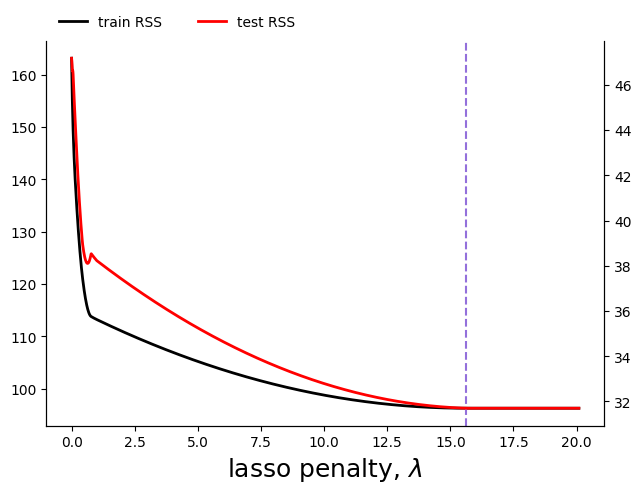

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(7.2, 5), sharex=True)

ax.plot(alphas, rss_train/len(X_train), label="train RSS", color="k", lw=2)

ax_t = ax.twinx()
ax_t.plot(alphas, rss_test/len(X_test), label="test RSS", color="red", lw=2)


ax.legend(loc="upper left", frameon=False, bbox_to_anchor=(0, 1.1))
ax_t.legend(loc="upper left", frameon=False, bbox_to_anchor=(0.25, 1.1))

ax.spines["top"].set_visible(False)
ax_t.spines["top"].set_visible(False)

ax.set_xlabel(r"lasso penalty, $\lambda$", fontsize=18)


λ_hat  = np.argmin(rss_test)
ax.axvline(alphas[λ_hat], color="mediumpurple", linestyle="--")



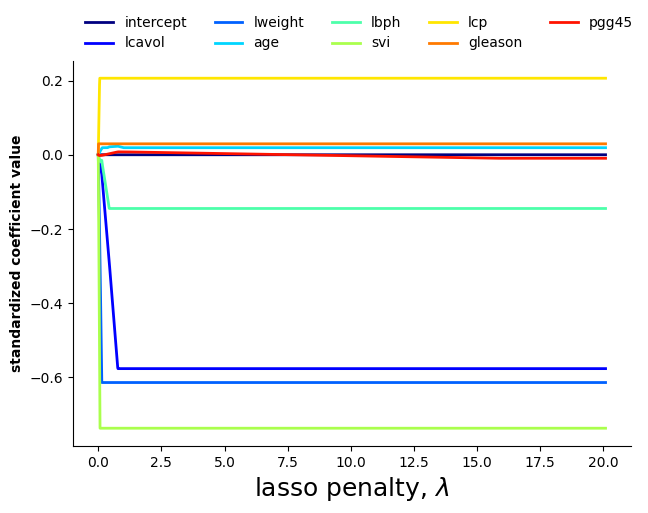

In [224]:
λ_hat  = np.argmin(rss_test)
labels = ["intercept"] + var_names
colors = plt.cm.jet(np.linspace(0, 1, len(labels)+1))

fig, ax = plt.subplots(1, 1, figsize=(7.2, 5), sharex=True)

for i_β in range(β_lasso.shape[1]):

    coefs_norm = β_lasso - np.expand_dims(β_lasso[0, :], 0)
    c   = colors[i_β]

    β_i = coefs_norm[:, i_β]
    ax.plot(alphas, β_i, label=labels[i_β], color=c, lw=2)

#ax.axvline(alphas[λ_hat]/np.sum(np.abs(coefs_norm[λ_hat, :])), color="mediumpurple", linestyle="--")

ax.set_xlabel(r"lasso penalty, $\lambda$", fontsize=18)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylabel(r"standardized coefficient value", weight="bold")
ax.legend(loc="upper left", frameon=False, bbox_to_anchor=(0.0, 1.15), ncol=5)

#ax.set_ylim(-0.035, 0.08113336113386853)